In [1]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import subprocess
import pickle
from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from lvmdrp.core import image
from lvmdrp.functions import imageMethod, rssMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

import warnings
warnings.filterwarnings("ignore")


def read_nist_reference(filename, wl_window):
    wli, wlf = wl_window
    ref_nist_or = pd.read_csv(
        filename, sep="\s+", comment="#").set_index("Wavelength")
    ref_nist_or = ref_nist_or.loc[(
        wli <= ref_nist_or.index) & (ref_nist_or.index <= wlf)]

    del_wl = np.diff(ref_nist_or.index).min()
    new_wl = np.unique(
        np.arange(wli, wlf+del_wl, del_wl).tolist()+ref_nist_or.index.to_list())
    ref_nist_rs = ref_nist_or.reindex(new_wl)

    return ref_nist_or, ref_nist_rs


In [2]:
from lvmdrp.main import load_master_config
from lvmdrp.utils.database import ReductionStatus, QualityFlag, create_or_connect_db, LVMFrames, get_raws_metadata


from lvmsurveysim.utils.sqlite2astropy import peewee2astropy


config = load_master_config()
create_or_connect_db(config)

lvm_frames = peewee2astropy(LVMFrames).to_pandas().set_index("id")

# 2246-2290 Darks (10 s, 30 s, 90 s)
# 2291-2335 Argon  (10 s, 30 s, 90 s)   
# 2336-2380 Xenon  (10 s, 30 s, 90 s)
# 2381-2425 Mercury-Argon  (10 s, 30 s, 90 s)
# 2426-2470 Neon  (10 s, 30 s, 90 s)
# 2471-2515 Mercury-Neon  (10 s, 30 s, 90 s)
targ_idxs = np.arange(2246, 2515+1, 1, dtype=int)
cont_idxs = np.asarray(list(range(2169,2183)) + list(range(2186,2200)))

In [3]:
cont_frames = lvm_frames.loc[lvm_frames.label.str.split("-").apply(lambda r: int(r[-1])).isin(cont_idxs)].sort_values("exptime", ascending=False)
targ_frames = lvm_frames.loc[lvm_frames.label.str.split("-").apply(lambda r: int(r[-1])).isin(targ_idxs)].sort_values("exptime", ascending=False)
targ_frames



,datetime,mjd,spec,ccd,exptime,imagetyp,obstime,observat,label,path,...,ffs,mi150,ts,ldls,nirled,reduction_started,reduction_finished,status,flags,calib_id
id,,,,,,,,,,,,,,,,,,,,,
13666,2022-11-23 07:48:04.226720,59646,sp1,z1,90.0,arc,2022-03-08T17:18:24.608,LCO,sdR-s-z1-00002373,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
13164,2022-11-23 07:48:04.130049,59646,sp1,b1,90.0,arc,2022-03-08T21:04:42.392,LCO,sdR-s-b1-00002508,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
13193,2022-11-23 07:48:04.131582,59646,sp1,b1,90.0,dark,2022-03-08T14:51:46.441,LCO,sdR-s-b1-00002283,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
13192,2022-11-23 07:48:04.131519,59646,sp1,b1,90.0,arc,2022-03-08T15:50:53.366,LCO,sdR-s-b1-00002322,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
13616,2022-11-23 07:48:04.221896,59646,sp1,z1,90.0,arc,2022-03-08T18:32:24.530,LCO,sdR-s-z1-00002417,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,2022-11-23 07:48:04.132599,59646,sp1,z1,10.0,arc,2022-03-08T16:39:21.479,LCO,sdR-s-z1-00002349,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
13207,2022-11-23 07:48:04.132650,59646,sp1,r1,10.0,arc,2022-03-08T17:45:31.663,LCO,sdR-s-r1-00002384,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None
13209,2022-11-23 07:48:04.132750,59646,sp1,z1,10.0,arc,2022-03-08T15:14:39.204,LCO,sdR-s-z1-00002293,/home/mejia/Research/UNAM/lvm-drp/data.sdss5.o...,...,0,0,0,0,0,None,None,1,1,None


In [4]:
# arc_path = targ_frames.loc[targ_frames.NEON=="ON"].iloc[-1].filepath
# subprocess.run(f"ds9 {arc_path}".split())
# cont_path = targ_frames.loc[targ_frames.LDLS=="ON"].iloc[-1].filepath
# subprocess.run(f"ds9 {cont_path}".split())

# 360-593 nm (Blue channel CCDs)
# 566-772 nm (Red channel CCDs)
# 747-980 nm (NIR channel CCDs)
CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}
CHANNEL = "b1"
ARC_NAME = "neon"
# ARC_NAME = "hgne"
# ARC_NAME = "hgar"
# ARC_NAME = "xenon"
# ARC_NAME = "krypton"
# iframe = -2
iframe = 0

mask_channel = targ_frames.label.str.contains(CHANNEL)
arc_path = targ_frames.loc[mask_channel&(targ_frames[ARC_NAME] == 1)].iloc[iframe].path
arc_name = os.path.basename(arc_path).replace(".fits.gz", "")

mask_channel = cont_frames.label.str.contains(CHANNEL)
cont_path = cont_frames.loc[mask_channel&(cont_frames.ldls == 1)].sort_values("exptime", ascending=False).iloc[0].path
cont_name = os.path.basename(cont_path).replace(".fits.gz", "")


cont_name, arc_name
fits.open(arc_path)[0].header, arc_path

(SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                   16 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                 4120                                                  
 NAXIS2  =                 4080                                                  
 FILENAME= 'sdR-s-b1-00002458.fits.gz' / File basename                           
 EXPNO   =                 2458 / Exposure number                                
 SPEC    = 'sp1     '           / Spectrograph name                              
 OBSERVAT= 'LCO     '           / Observatory                                    
 OBSTIME = '2022-03-08T19:36:28.869' / Start of the observation                  
 MJD     =                59646 / Modified Julian Date                           
 EXPTIME =                 90.0 / Exposure time                                  
 DARKTIME=      

In [5]:
# imageMethod.preprocRawFrame_drp(
# 	in_image=cont_path,
# 	out_image=f"_data-lvm/{cont_name}.pre.fits",
# 	boundary_x="1,2040",
# 	boundary_y="1,2040",
# 	positions="00,10,01,11",
# 	orientation="S,S,S,S"
# )
# # subprocess.run(f"ds9 _data-lvm/{cont_name}.pre.fits".split())

# # imageMethod.LACosmic_drp(
# #     image=f"_data-lvm/{cont_name}.pre.fits",
# #     out_image=f"_data-lvm/{cont_name}.cosmic.fits",
# #     increase_radius=1, flim="1.3", parallel='5'
# # )

# imageMethod.findPeaksAuto_drp(
#     image=f"_data-lvm/{cont_name}.pre.fits",
#     out_peaks_file=f"_data-lvm/{cont_name}.trace.peaks",
#     disp_axis="X", threshold="5000", slice="3696", nfibers="41", median_box="1", median_cross="1", method="gauss", init_sigma="0.5", verbose=1
# )

# imageMethod.tracePeaks_drp(
#     image=f"_data-lvm/{cont_name}.pre.fits",
#     peaks_file=f"_data-lvm/{cont_name}.trace.peaks", trace_out=f"_data-lvm/{cont_name}.trc.fits",
#     steps=30, method="gauss", threshold_peak=50, poly_disp=5, coadd=30, verbose=0
# )
# pre = fits.open(f"_data-lvm/{cont_name}.pre.fits")
# trace = fits.open(f"_data-lvm/{cont_name}.trc.fits")

# plt.figure(figsize=(17,10))
# plt.imshow(np.log10(pre[0].data), origin="lower")
# plt.gca().set_aspect("auto")
# plt.xlim(0,2000)
# plt.ylim(2000,2300)
# plt.xlabel("dispersion axis (pixel)")
# plt.ylabel("cross-dispersion axis (pixel)")

# xx = np.arange(pre[0].data.shape[1])
# for iy in range(trace[0].data.shape[0]):
#     yy = trace[0].data[iy,:]
#     plt.plot(xx, yy, "--")

# imageMethod.subtractStraylight_drp(
#     image=f"_data-lvm/{cont_name}.pre.fits",
#     trace=f"_data-lvm/{cont_name}.trc.fits",
#     stray_image=f"_data-lvm/{cont_name}.back.fits",
#     clean_image=f"_data-lvm/{cont_name}.stray.fits",
#     aperture=40, poly_cross=2, smooth_gauss=30
# )
# # subprocess.run(f"ds9 _data-lvm/{cont_name}.pre.fits _data-lvm/{cont_name}.stray.fits".split(), capture_output=True)

# imageMethod.traceFWHM_drp(
#     image=f"_data-lvm/{cont_name}.stray.fits",
#     trace=f"_data-lvm/{cont_name}.trc.fits",
#     fwhm_out=f"_data-lvm/{cont_name}.fwhm.fits",
#     blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0"
# )
# # subprocess.run(f"ds9 _data-lvm/{cont_name}.fwhm.fits".split())

# # imageMethod.extractSpec_drp(
# #     image=f"_data-lvm/{cont_name}.stray.fits",
# #     trace=f"_data-lvm/{cont_name}.trc.fits",
# #     out_rss=f"_data-lvm/{cont_name}.ms.fits",
# #     fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
# #     parallel=5, method="optimal"
# # )

In [6]:
# # extraccion del arco
# imageMethod.preprocRawFrame_drp(
# 	in_image=arc_path,
# 	out_image=f"_data-lvm/{arc_name}.pre.fits",
# 	boundary_x="1,2040",
# 	boundary_y="1,2040",
# 	positions="00,10,01,11",
# 	orientation="S,S,S,S"
# )
# # subprocess.run(f"ds9 _data-lvm/{arc_name}.pre.fits".split())

# # imageMethod.LACosmic_drp(
# #     image=f"_data-lvm/{arc_name}.pre.fits",
# #     out_image=f"_data-lvm/{arc_name}.cosmic.fits",
# #     increase_radius=1, flim="1.3", parallel='5'
# # )
# imageMethod.subtractStraylight_drp(
#     image=f"_data-lvm/{arc_name}.pre.fits",
#     trace=f"_data-lvm/{cont_name}.trc.fits",
#     stray_image=f"_data-lvm/{arc_name}.back.fits",
#     clean_image=f"_data-lvm/{arc_name}.stray.fits",
#     aperture=40, poly_cross=2, smooth_gauss=30
# )
# imageMethod.extractSpec_drp(
#     image=f"_data-lvm/{arc_name}.stray.fits",
#     trace=f"_data-lvm/{cont_name}.trc.fits",
#     out_rss=f"_data-lvm/{arc_name}.ms.fits",
#     fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
#     method="optimal", parallel="5"
# )

# # subprocess.run(f"ds9 _data-lvm/{arc_name}.ms.fits".split())


In [7]:
wli, wlf = CHANNEL_WL[CHANNEL]
ised = 21
coad = 10

# neon_ref = pd.read_csv("_data-lvm/neon-lines_desi.txt", sep="\s+", comment="#", names=["Wavelength", "Spectrum", "Spectrograph"]).sort_values("Wavelength").set_index("Wavelength")
# neon_cur_ref = neon_ref.Spectrum
# neon_cur_ref = neon_cur_ref.str.strip().str.isalpha().astype(int)
# neon_cur_ref = neon_cur_ref.loc[(wli<=neon_cur_ref.index)&(neon_cur_ref.index<=wlf)]
# neon_cur_ref = neon_cur_ref.loc[neon_cur_ref!=0]

# print(len(neon_cur_ref))

# del_wl = np.diff(neon_cur_ref.index).min()
# new_wl = np.unique(np.arange(wli, wlf+del_wl, del_wl).tolist()+neon_cur_ref.index.to_list())
# neon_spec = neon_cur_ref.reindex(new_wl).fillna(0)
# # neon_spec.plot(figsize=(17,5))
# # plt.gca().set_yscale("log")

ext, ext_header = fits.getdata(f"_data-lvm/{arc_name}.ms.fits", header=True)
targ_spec = ext[ised-coad:ised+coad].sum(axis=0)
# targ_spec[targ_spec<targ_spec.std()] = 0

In [8]:
neon_nist_or, neon_nist = read_nist_reference("_data-lvm/neon-lines-nist.txt", wl_window=(wli,wlf))
xenon_nist_or, xenon_nist = read_nist_reference("_data-lvm/xenon-lines-nist.txt", wl_window=(wli,wlf))
argon_nist_or, argon_nist = read_nist_reference("_data-lvm/argon-lines-nist.txt", wl_window=(wli,wlf))
mercury_nist_or, mercury_nist = read_nist_reference("_data-lvm/mercury-lines-nist.txt", wl_window=(wli,wlf))

# ref_current = (mercury_nist_or, argon_nist_or)
# ref_current = (mercury_nist_or, neon_nist_or)
ref_current = (neon_nist_or,)
# ref_current = (xenon_nist_or,)

ref_lines = pd.concat(ref_current, axis="columns")
print(ref_lines.shape)
ref_gr = ref_lines.groupby(ref_lines.columns, axis="columns")

ref_lines = pd.concat((
    ref_gr.get_group("Intensity").agg(np.nansum, axis="columns"),
    ref_gr.get_group("Spectrum").fillna("").agg(
        lambda v: "".join(v), axis="columns")
), axis="columns").rename(columns={0: "Intensity", 1: "Spectrum"})

(64, 2)


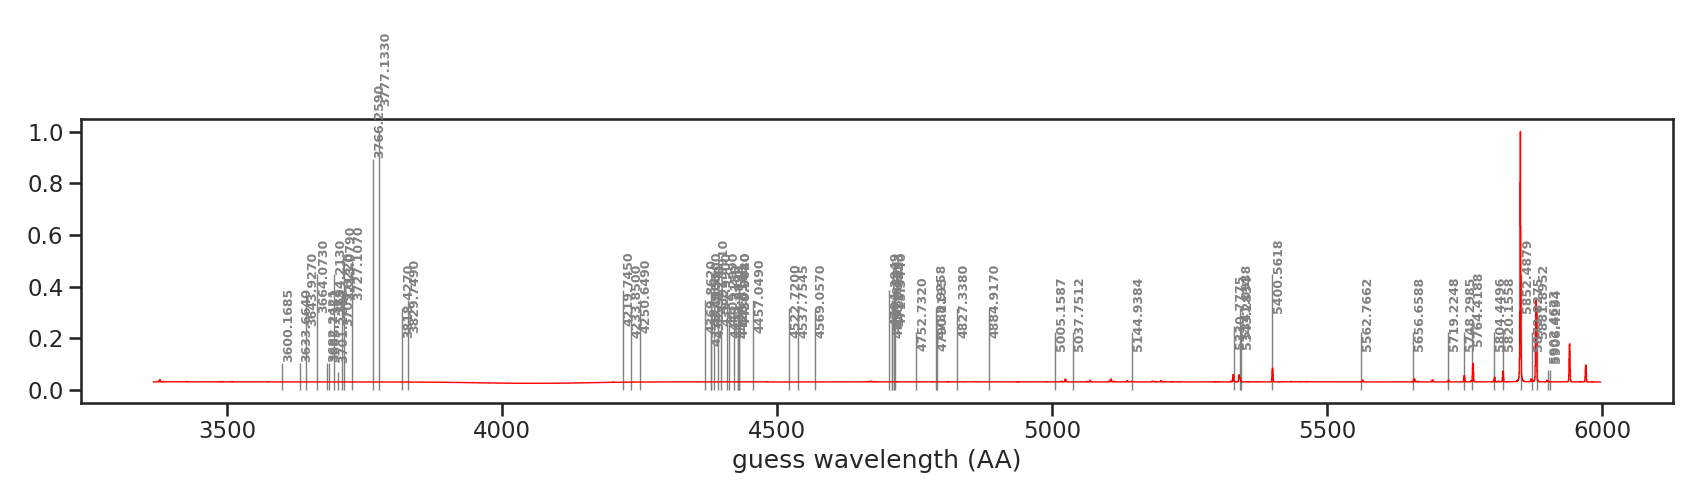

In [9]:
import matplotlib.ticker as plticker


# initial guess: a linear interpolation in the known range
guess_wl = np.linspace(wli, wlf, targ_spec.size)

plt.figure(figsize=(17,5))
# plt.vlines(neon_cur_ref.index, ymin=0, ymax=1, colors="0.2", lw=1)
plt.vlines(ref_lines.index, ymin=0, ymax=np.sqrt(0.001+ref_lines.Intensity/ref_lines.Intensity.max()), colors="0.5", lw=1)
if CHANNEL == "b1":
    mask_bad = (4515-5<=guess_wl)&(guess_wl<=4515+5)
    # mask_bad = np.zeros_like(guess_wl, dtype=bool)
    targ_spec[mask_bad] = 0
    plt.step(
        # guess_wl,
        -0.00009*(guess_wl + (83 - 5400.5618))**2 + \
        1.03*(guess_wl + (83 - 5400.5618)) + 5400.5618,
        np.sqrt(0.001+targ_spec/targ_spec.max()), color="r", lw=1)
elif CHANNEL == "r1":
    plt.step(
        # guess_wl,
        -0.00001*(guess_wl + (80.5 - 6929.4673))**2 + 1.05*(guess_wl + (80.5 - 6929.4673)) + 6929.4673,
        (targ_spec/targ_spec.max()), color="r", lw=1
    )
elif CHANNEL == "z1":
    # best guess for NIR channel
    plt.step(1.05*(guess_wl+110-8860)+8860, (targ_spec[::]/targ_spec.max()), color="r", lw=1)

for iwl, line in ref_lines.iterrows():
    rel_intensity = (line.Intensity/ref_lines.Intensity.max())
    if rel_intensity > -0.1:
        plt.text(iwl, rel_intensity+0.1,
             f"{iwl:.4f}", rotation=90, ha="left", va="bottom", size=9, color="0.5", fontweight="bold")
plt.xlabel("guess wavelength (AA)")
# plt.yscale("log")
# this locator puts ticks at regular intervals
# loc = plticker.MultipleLocator(base=100)
# plt.gca().xaxis.set_major_locator(loc)
plt.tight_layout()
# neon_spec.mask(neon_spec==0).dropna()
# plt.xlim(3580, 4700)

In [10]:
# np.seterr(all="raise")

wave, fwhm, _ = rssMethod.detWaveSolution_drp(
# rssMethod.detWaveSolution_drp(
    arc_rss=f"_data-lvm/{arc_name}.ms.fits",
    disp_rss=f"_data-lvm/{arc_name}.disp.fits",
    res_rss=f"_data-lvm/{arc_name}.res.fits",
    ref_line_file=f"_data-lvm/new-{ARC_NAME}_nist_{CHANNEL}.txt",
    aperture="7", poly_fwhm="-5,-1", poly_dispersion="-4", rel_flux_limits="0.2,2", flux_min="100.0", verbose="-1"
)
# subprocess.run(f"ds9 {arc_name}.disp.fits {arc_name}.res.fits".split())

rssMethod.createPixTable_drp(
    rss_in=f"_data-lvm/{arc_name}.ms.fits",
    rss_out=f"_data-lvm/{arc_name}.rss.fits",
    arc_wave=f"_data-lvm/{arc_name}.disp.fits",
    arc_fwhm=f"_data-lvm/{arc_name}.res.fits",
    cropping=''
)

# remuestrea los espectros a un vector de longitudes de onda comun. Crea *.disp_cor
rssMethod.resampleWave_drp(
    rss_in=f"_data-lvm/{arc_name}.rss.fits",
    rss_out=f"_data-lvm/{arc_name}.disp_cor.fits",
    start_wave=wli, end_wave=wlf, disp_pix=1, err_sim="0", parallel=0
)

# subprocess.run(f"ds9 _data-lvm/{arc_name}.rss.fits _data-lvm/{arc_name}.disp_cor.fits".split())

Start measuring arc lines...


In [11]:
f = fits.open(f"_data-lvm/{arc_name}.disp.fits")
*f[0].data[ised,[0,-1]], (wli, wlf), arc_name

(3590.2556, 6003.2876, (3600, 5930), 'sdR-s-b1-00002458')

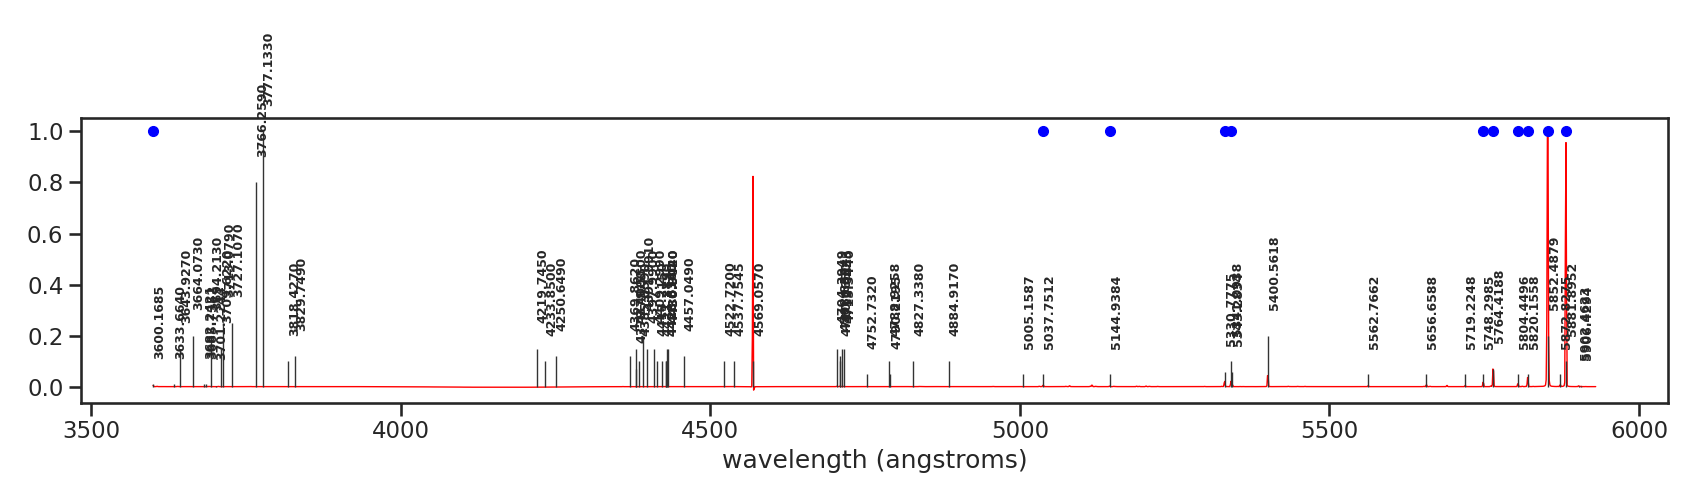

In [12]:
rss = rssMethod.loadRSS(f"_data-lvm/{arc_name}.disp_cor.fits")
sed = rss._data[ised-coad:ised+coad].sum(axis=0)

ref_table = np.loadtxt(f"_data-lvm/new-{ARC_NAME}_nist_{CHANNEL}.txt", skiprows=1)
ref_table = ref_table[ref_table[:,2].astype(bool)]

plt.figure(figsize=(17,5))
plt.plot(rss._wave, (1e-3+rss._data[ised]/rss._data[ised].max()), "r", lw=1)
plt.plot(ref_table[:,1], np.ones_like(ref_table[:,1]), "ob", ms=7)
plt.vlines(ref_lines.index, ymin=0, ymax=(ref_lines.Intensity/ref_lines.Intensity.max()), colors="0.2", lw=1)

for iwl, line in ref_lines.iterrows():
    rel_intensity = (line.Intensity/ref_lines.Intensity.max())
    if rel_intensity > -0.1:
        plt.text(iwl, rel_intensity+0.1,
             f"{iwl:.4f}", rotation=90, ha="left", va="bottom", size=9, fontweight="bold")

plt.xlabel("wavelength (angstroms)")
# plt.ylabel("normalized counts")
plt.tight_layout()

In [13]:
# TODO: implement coefficients storing for the wavelength solution and the LSF

f = fits.open(f"_data-lvm/{arc_name}.rss.fits")
f.info()

Filename: _data-lvm/sdR-s-b1-00002458.rss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      69   (4079, 41)   float32   
  1  WAVE          1 ImageHDU         8   (4079, 41)   float32   
  2  INSTFWHM      1 ImageHDU         8   (4079, 41)   float32   
  3  ERROR         1 ImageHDU         8   (4079, 41)   float32   
  4  BADPIX        1 ImageHDU         8   (4079, 41)   uint8   


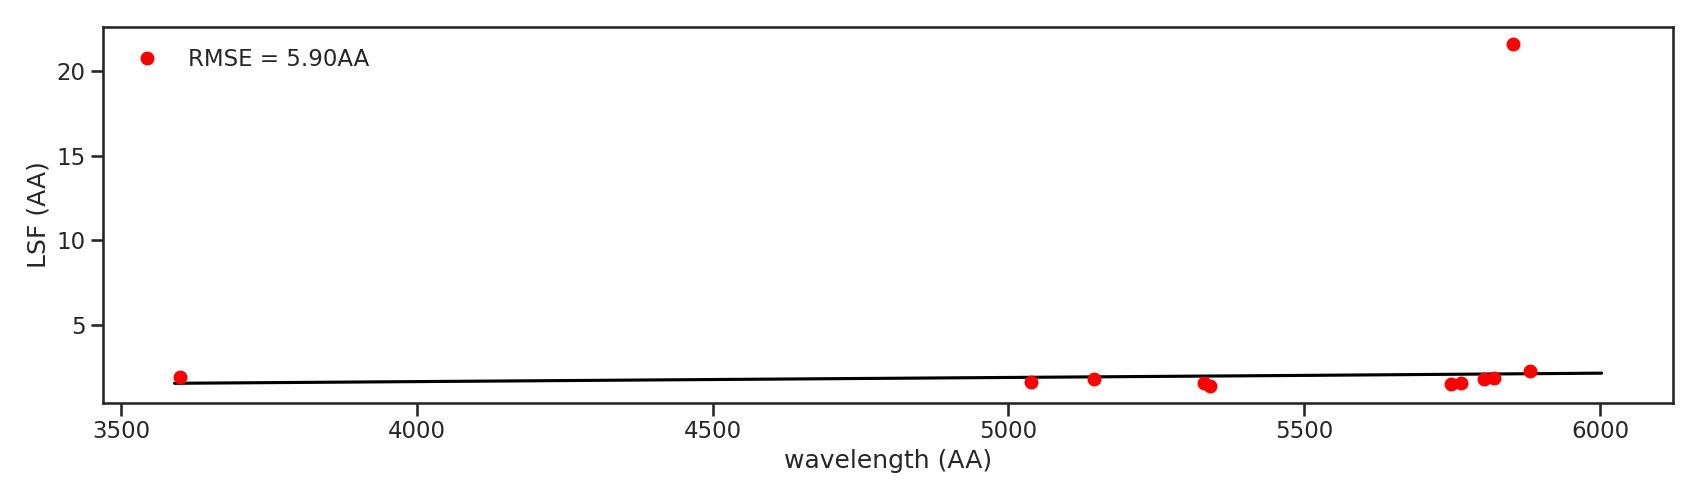

In [14]:
def rmse(model, data):
    return np.sqrt(np.sum((model-data)**2)/data.size)

plt.figure(figsize=(17,5))
plt.plot(f[1].data[ised], f[2].data[ised], "k")

error = rmse(np.interp(ref_table[:,1], f[1].data[ised], f[2].data[ised]), fwhm)
plt.plot(ref_table[:,1], fwhm, "or", label=f"RMSE = {error:.2f}AA")

plt.legend(loc=0, frameon=False)
plt.xlabel("wavelength (AA)")
plt.ylabel("LSF (AA)")
plt.tight_layout()

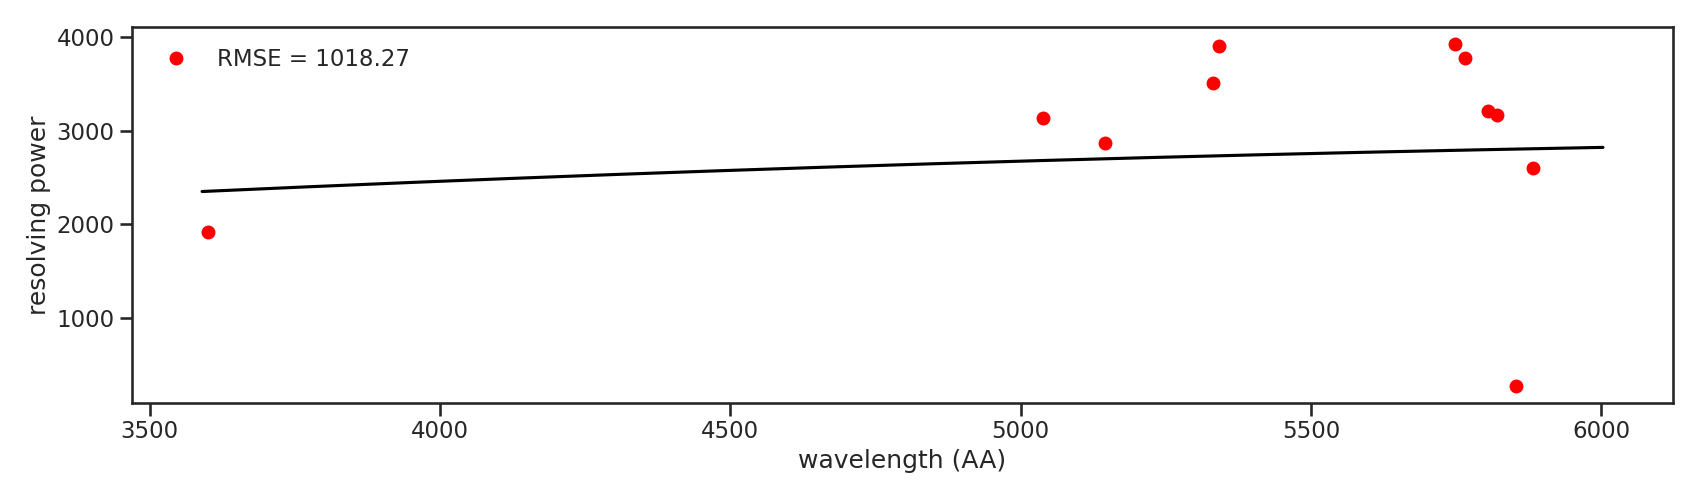

In [15]:


plt.figure(figsize=(17,5))
plt.plot(f[1].data[ised], f[1].data[ised]/f[2].data[ised], "k")

error = rmse(np.interp(ref_table[:,1], f[1].data[ised], f[1].data[ised]/f[2].data[ised]), ref_table[:,1]/fwhm)
plt.plot(ref_table[:,1], ref_table[:,1]/fwhm, "or", label=f"RMSE = {error:.2f}")

plt.legend(loc=0, frameon=False)
plt.xlabel("wavelength (AA)")
plt.ylabel("resolving power")
plt.tight_layout()

In [16]:
# from lvmdrp.core.spectrum1d import Spectrum1D


# ref_rss = []
# for ifib in range(f[0].header["NAXIS2"]):
#     ref_wl = np.unique(ref_lines.index.tolist() + f["WAVE"].data[ifib].tolist())
#     del_wl = 0.5
#     sup_wl = np.arange(ref_wl.min(), ref_wl.max()+del_wl, del_wl)
#     ref_sed = np.interp(sup_wl, ref_lines.index, ref_lines.Intensity)
#     ref_lsf = np.ones_like(sup_wl)*del_wl*2.354

#     ref_spec = Spectrum1D(wave=sup_wl, data=ref_sed, inst_fwhm=ref_lsf)
#     ref_spec.matchFWHM(np.interp(sup_wl, f["WAVE"].data[ifib], f["INSTFWHM"].data[ifib]))
#     ref_rss.append(ref_spec.resampleSpec(f["WAVE"].data[ifib])._data)

# ref_rss = np.asarray(ref_rss)


In [17]:
# plt.figure(figsize=(15,5))
# plt.plot(ref_lines.index, ref_lines.Intensity)
# plt.plot(f["WAVE"].data[ised], ref_rss[ised])
# plt.show()

In [18]:
# from scipy.spatial.distance import euclidean, cosine
# from fastdtw import fastdtw
# from dtaidistance import dtw
# from dtaidistance import dtw_visualisation as dtwvis
# from scipy.ndimage import gaussian_filter1d


# def refine_wave_solution(rss_in, ref_lines_files, row, aperture, metric_func, norm_func=None, zero_threshold=1e-5, verbose=1):
#     """refine the wavelength solution using DTW
    
#     Parameters
#     ----------
#     rss_in: input RSS file with extracted spectra in the first HDU
#     ref_lines_files: reference lines list file or files
#     row: target spectrum in the RSS
#     aperture: maximum number of pixels to look for a match
#     metric_func: the distance metric to use. It should take to arrays of the same size and return a scalar
#     norm_func: normalization function to use to apply to both spectra. It should take one array and return an array of the same size
#     """

#     rss = fits.open(rss_in)
#     tar_wl, tar_spec = rss[1].data[row], rss[0].data[row]
#     wli, wlf = tar_wl.min(), tar_wl.max()

#     if isinstance(ref_lines_files, str):
#         ref_lines_or, _ = read_nist_reference(ref_lines_files, wl_window=(wli, wlf))
#     elif isinstance(ref_lines_files, (tuple, list)):
#         ref_lines_or_list = []
#         for ref_lines_file in ref_lines_files:
#             ref_lines_or, _, = read_nist_reference(ref_lines_file, wl_window=(wli, wlf))
#             ref_lines_or_list.append(ref_lines_or)
#         ref_lines_or = pd.concat(ref_lines_or_list, axis="index")
    
#     ref_wl = np.unique(tar_wl.tolist()+ref_lines.index.tolist())
#     ref_spec = ref_lines_or.reindex(ref_wl, fill_value=0).Intensity.values
    
#     # resample and downgrade resolution of reference spectrum
#     delt = np.diff(tar_wl).min()
#     sup_wl = np.arange(wli, wlf+delt/3, delt/3)
#     sup_spec = np.interp(sup_wl, ref_wl, ref_spec)
#     sup_spec = gaussian_filter1d(sup_spec, sigma=1.8/delt)
#     ref_spec = np.interp(tar_wl, sup_wl, sup_spec)

#     # apply normalization
#     if norm_func is not None:
#         tar_spec = norm_func(tar_spec).astype(np.double)
#         ref_spec = norm_func(ref_spec).astype(np.double)
    
#     # target spectrum cleaning of noise
#     tar_spec[np.abs(tar_spec)<zero_threshold] = 0.0

#     if verbose:
#         print("initial distance:", metric_func(ref_spec, tar_spec))
#         plt.figure(figsize=(17,5))
#         plt.plot(tar_wl, ref_spec, "-", lw=1, color="0.5")
#         plt.plot(tar_wl, tar_spec, "-", lw=1, color="r")

#     # dist, path = fastdtw(tar_spec, ref_spec, dist=metric_func, radius=aperture)
#     dist, paths = dtw.warping_paths(ref_spec, tar_spec, psi=500, window=aperture, use_pruning=False, use_c=True)
#     path = dtw.best_path(paths)
#     if verbose:
#         print("final distance:", dist)
#         dtwvis.plot_warpingpaths(ref_spec, tar_spec, paths, path)
    
#     return dist, path, tar_wl, tar_spec, ref_wl, ref_spec


# dist, path, tar_wl, tar_spec, ref_wl, ref_spec = refine_wave_solution(
#     rss_in=f"_data-lvm/{arc_name}.rss.fits",
#     # ref_lines_files=(f"_data-lvm/neon-lines-nist.txt", f"_data-lvm/mercury-lines-nist.txt"),
#     ref_lines_files=(f"_data-lvm/neon-lines-nist.txt",),
#     row=ised,
#     aperture=None,
#     metric_func=euclidean,
#     norm_func=lambda spec: np.sqrt(1e-3+np.log10(1+spec/spec.max())),
#     zero_threshold=1e-6,
#     verbose=1
# )
# ineon, itarget = zip(*path)
# ineon, itarget = list(ineon), list(itarget)

In [19]:
# f = fits.open(f"_data-lvm/{arc_name}.rss.fits")
# rss = rssMethod.loadRSS(f"_data-lvm/{arc_name}.disp_cor.fits")

# plt.figure(figsize=(17,5))
# plt.plot(ref_wl[ineon], ref_spec[ineon], lw=0.5, color="0.2")
# plt.plot(tar_wl[itarget], tar_spec[itarget], lw=1, color="r")
# # plt.plot(f[1].data[ised][itarget], f[0].data[ised][itarget]/f[0].data[ised].max(), lw=1, color="r")

# plt.figure(figsize=(17,5))
# plt.plot(rss._wave, (1e-3+rss._data[ised]/rss._data[ised].max()), "r", lw=1)
# plt.plot(ref_table[:,1], np.ones_like(ref_table[:,1]), "ob", ms=7)
# plt.vlines(ref_lines.index, ymin=0, ymax=(ref_lines.Intensity/ref_lines.Intensity.max()), colors="0.2", lw=1)

# for iwl, line in ref_lines.iterrows():
#     rel_intensity = (line.Intensity/ref_lines.Intensity.max())
#     if rel_intensity > -0.1:
#         plt.text(iwl, rel_intensity+0.1,
#              f"{iwl:.4f}", rotation=90, ha="left", va="bottom", size=9, fontweight="bold")

# plt.xlabel("wavelength (angstroms)")
# # plt.ylabel("normalized counts")
# plt.tight_layout()

# # mask = (ref_spec[ineon]!=0)&(f[0].data[ised][itarget]>1*np.std(f[0].data[ised][itarget]))
# # pix_map_table = np.column_stack((np.arange(f[0].data[ised].size)[itarget], ref_wl[ineon], np.ones(len(ineon))))[mask]
# # pix_map_table
# # _, idx = np.unique(pix_map_table[:,1], return_index=True)
# # with open(f"_data-lvm/dtw-{ARC_NAME}.txt", "w") as f:
# #     f.write(f"{ised}\n")
# #     np.savetxt(f, pix_map_table[idx], fmt="%.2f %.2f %d")